In [ ]:
!pip install qutip

In [ ]:
!pip install krotov

In [3]:
import sys
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from scipy.fftpack import fft
from scipy.interpolate import interp1d


In [4]:
def guess_control1(t, args , ampl0=0.2):
    return ampl0 * krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
    )
def guess_control2(t , args,ampl0=0.2):
    return ampl0 * krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
    )

In [5]:
def hamiltonian(omega=1 , ampl0=0.2 ):
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()
    H2 = qutip.operators.sigmay()

    return [H0,[H1,guess_control1],[H2,guess_control2]]


In [6]:
H = hamiltonian()
H

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[-0.5  0. ]
  [ 0.   0.5]],
 [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
  Qobj data =
  [[0. 1.]
   [1. 0.]],
  <function __main__.guess_control1(t, args, ampl0=0.2)>],
 [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
  Qobj data =
  [[0.+0.j 0.-1.j]
   [0.+1.j 0.+0.j]],
  <function __main__.guess_control2(t, args, ampl0=0.2)>]]

In [7]:
tlist = np.linspace(0, 5, 500)

In [8]:
def logical_basis(H):
    H0 = H[0]
    eigenvals, eigenvecs = scipy.linalg.eig(H0.full())
    ndx = np.argsort(eigenvals.real)
    E = eigenvals[ndx].real
    V = eigenvecs[:, ndx]
    psi0 = qutip.Qobj(V[:, 0])
    psi1 = qutip.Qobj(V[:, 1])
    w01 = E[1] - E[0]  # Transition energy between states
    print("Energy of qubit transition is %.3f" % w01)
    return psi0, psi1

psi0, psi1 = logical_basis(H)

Energy of qubit transition is 1.000


In [9]:
proj0 = qutip.ket2dm(psi0)
proj1 = qutip.ket2dm(psi1)

In [10]:
objectives = krotov.gate_objectives(
    basis_states=[psi0, psi1], gate=qutip.operators.sigmax(), H=H
)

objectives

[Objective[|Ψ₀(2)⟩ to |Ψ₁(2)⟩ via [H₀[2,2], [H₁[2,2], u₁(t)], [H₂[2,2], u₂(t)]]],
 Objective[|Ψ₁(2)⟩ to |Ψ₀(2)⟩ via [H₀[2,2], [H₁[2,2], u₁(t)], [H₂[2,2], u₂(t)]]]]

In [11]:
def plot_population(result):
    '''Representation of the expected values for the initial states'''
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

In [12]:
def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='blackman'
    )

pulse_options = {H[1][1]: dict(lambda_a=1, update_shape=S)}

In [13]:
pulse_options = {
    H[1][1]: dict(lambda_a=1, update_shape=S),
    H[2][1]: dict(lambda_a=1, update_shape=S)
}

In [ ]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.51e-01    0.00e+00   9.51e-01        n/a        n/a     3
1     4.41e-01    1.13e-01   5.54e-01  -5.09e-01  -3.96e-01     7
2     5.87e-03    1.76e-01   1.82e-01  -4.35e-01  -2.60e-01     7
3     1.98e-05    2.71e-03   2.73e-03  -5.85e-03  -3.14e-03     7


In [ ]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2023-01-22 08:47:33
- Number of objectives: 2
- Number of iterations: 3
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2023-01-22 08:47:58 (0:00:25)

In [ ]:
def plot_pulse(pulse, tlist, xlimit=None):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time (ns)')
    ax.set_ylabel('pulse amplitude')
    if xlimit is not None:
        ax.set_xlim(xlimit)
    plt.show(fig)

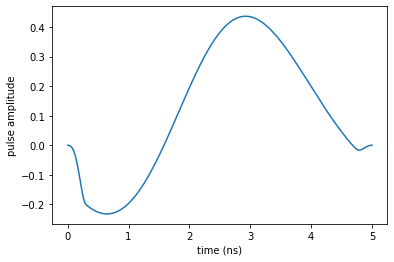

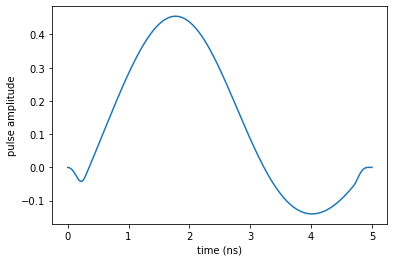

In [ ]:
plot_pulse(opt_result.optimized_controls[0], tlist)

plot_pulse(opt_result.optimized_controls[1], tlist)

In [ ]:
opt_dynamics1 = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1])

opt_dynamics2 = opt_result.optimized_objectives[1].mesolve(
    tlist, e_ops=[proj0, proj1])

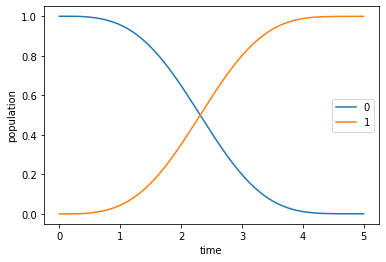

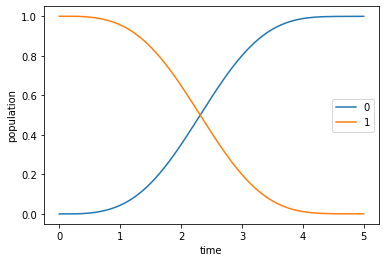

In [ ]:
plot_population(opt_dynamics1)
plot_population(opt_dynamics2)